In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/kaggle/W07_Kannada MNIST

/content/drive/My Drive/kaggle/W07_Kannada MNIST


# 1. 데이터 불러오기 및 탐색

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1-1. train, test 불러오기

In [5]:
try:
  train  = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
  test = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')
except:
  train = pd.read_csv('train.csv.zip')
  test = pd.read_csv('test.csv.zip')

In [6]:
print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

Train data shape: (60000, 785)
Test data shape: (5000, 785)


## 1-2. label 분포 확인하기

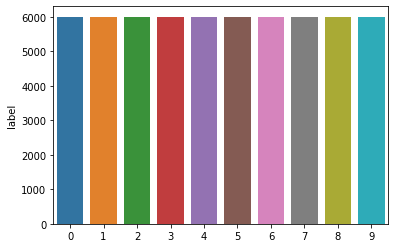

In [7]:
# label 분포 확인
label = train['label'].value_counts()
sns.barplot(label.index, label)
plt.show()

## 1-3. 각 label 시각화 해보기

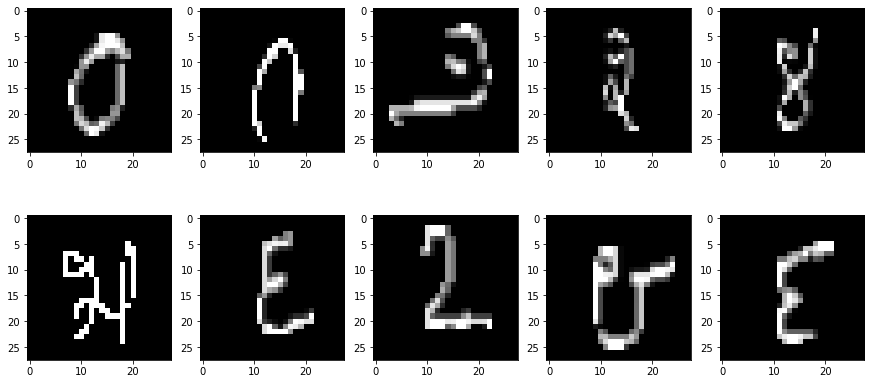

In [8]:
plt.figure(figsize = (15, 7))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    number = train.iloc[i, 1:].values.reshape(28, 28)
    plt.imshow(number, cmap='gray', interpolation='nearest')  

# 2. 데이터 전처리

## 2-1. 픽셀 정규화

In [9]:
# 각 픽셀의 범위는 0~255 -> 0~1로 정규화
# train
X = train.iloc[:, 1:].values.astype('float32') / 255
y = train['label']

In [10]:
# test
x_test = test.iloc[:, 1:].values.astype('float32') / 255

## 2-2. 이미지 처리를 위한 reshape

In [11]:
# 픽셀 데이터 reshape
X = X.reshape(-1, 28, 28,1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [12]:
X.shape, x_test.shape

((60000, 28, 28, 1), (5000, 28, 28, 1))

In [13]:
# label 인코딩
pd.get_dummies(y).values

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [14]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

## 2-3. 교차 검증을 위한 train-valid split

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [16]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

# 3. 모델링

## 3-1. Import Modules

In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D, LeakyReLU, ReLU, PReLU
from tensorflow.keras.optimizers import RMSprop, Nadam, Adadelta, Adam

## 3-2. 딥러닝 기본(MLP)

In [18]:
model = Sequential() # 모델 생성
model.add(Flatten(input_shape=[28, 28])) # mlp 학습을 위해 1차원으로 flatten
model.add(Dense(300, activation='relu')) # hidden layer 뉴런=300 
model.add(Dense(100, activation='relu')) # 활성화함수 = relu
model.add(Dense(10, activation='softmax')) # 10개의 클래스 출력값 => 다중분류 softmax
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(loss = 'categorical_crossentropy', # 손실함수
             optimizer = 'adam', # 최적화
             metrics = ['accuracy']) # 정확도

In [20]:
history = model.fit(x_train, y_train, epochs=30,
                   validation_data = (x_val, y_val))

Epoch 1/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1381 - accuracy: 0.9604 - val_loss: 0.0673 - val_accuracy: 0.9792
Epoch 2/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0476 - accuracy: 0.9857 - val_loss: 0.0485 - val_accuracy: 0.9852
Epoch 3/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0287 - accuracy: 0.9910 - val_loss: 0.0489 - val_accuracy: 0.9865
Epoch 4/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0197 - accuracy: 0.9936 - val_loss: 0.0569 - val_accuracy: 0.9835
Epoch 5/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0143 - accuracy: 0.9954 - val_loss: 0.0610 - val_accuracy: 0.9846
Epoch 6/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.0577 - val_accuracy: 0.9862
Epoch 7/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0091 - accuracy: 0.9970 - val_loss: 0.0600 - val_accuracy:

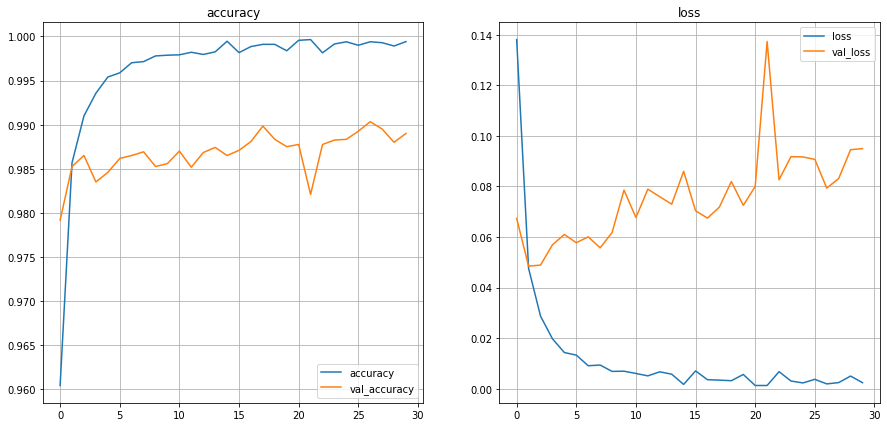

In [21]:
f, ax = plt.subplots(1,2, figsize = (15, 7))
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax = ax[0])
ax[0].grid(True)
ax[0].set_title('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax = ax[1])
ax[1].grid(True)
ax[1].set_title('loss')

plt.show()

## 3-3. SOPCNN

[Stochastic Optimization of Plain Convolutional Neural
Networks with Simple methods (2020, Yahia Saeed Assiri)](https://arxiv.org/pdf/2001.08856v1.pdf)

- MNIST 2020년 SOTA인 SOPCNN

In [22]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dense(2048),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)       

In [24]:
optimizer = Adam(learning_rate=0.01) # 논문 설정대로 0.01을 주었다.

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

In [25]:
history = model.fit(x_train, y_train, epochs=30,
                   validation_data = (x_val, y_val))

Epoch 1/30
1500/1500 [==============================] - 17s 12ms/step - loss: 29.9529 - accuracy: 0.8936 - val_loss: 6.3020 - val_accuracy: 0.9740
Epoch 2/30
1500/1500 [==============================] - 17s 12ms/step - loss: 462.1909 - accuracy: 0.9565 - val_loss: 46.1067 - val_accuracy: 0.9887
Epoch 3/30
1500/1500 [==============================] - 17s 12ms/step - loss: 58.7553 - accuracy: 0.9805 - val_loss: 19.1989 - val_accuracy: 0.9918
Epoch 4/30
1500/1500 [==============================] - 17s 12ms/step - loss: 206.0641 - accuracy: 0.9763 - val_loss: 195.3885 - val_accuracy: 0.9843
Epoch 5/30
1500/1500 [==============================] - 17s 12ms/step - loss: 159.7476 - accuracy: 0.9815 - val_loss: 216.0838 - val_accuracy: 0.9891
Epoch 6/30
1500/1500 [==============================] - 17s 12ms/step - loss: 275.3051 - accuracy: 0.9813 - val_loss: 138.2755 - val_accuracy: 0.9908
Epoch 7/30
1500/1500 [==============================] - 17s 12ms/step - loss: 314.1844 - accuracy: 0.9840 

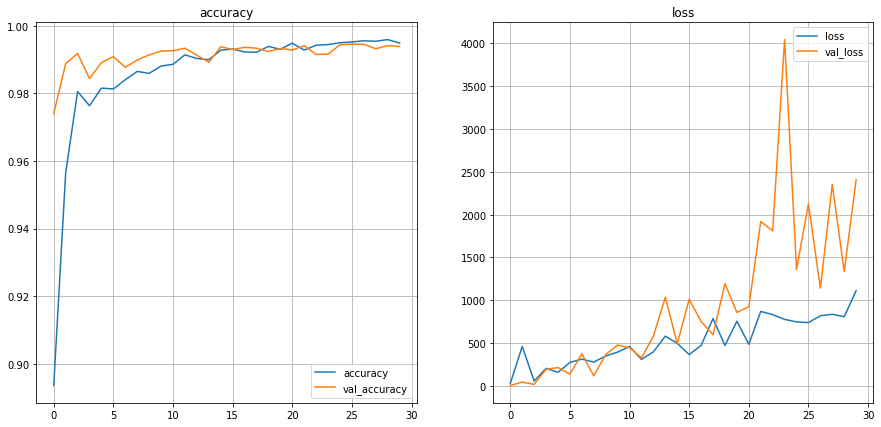

In [26]:
f, ax = plt.subplots(1,2, figsize = (15, 7))
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax = ax[0])
ax[0].grid(True)
ax[0].set_title('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax = ax[1])
ax[1].grid(True)
ax[1].set_title('loss')

plt.show()

## 3-4. Data Augmentation + SOPCNN

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
datagen_train = ImageDataGenerator(rotation_range = 15, # 돌리는 각도 
                             width_shift_range = 0.15, # 0.15 우로 이동, 1 이상이면 픽셀 수로 변환
                             height_shift_range = 0.15, # 0.15 위로 이동, 1 이상이면 픽셀 수로 변환
                             shear_range = 0.15, # 휘어짐 정도
                             zoom_range = 0.4,) # 확대 정도

datagen_train.fit(x_train)

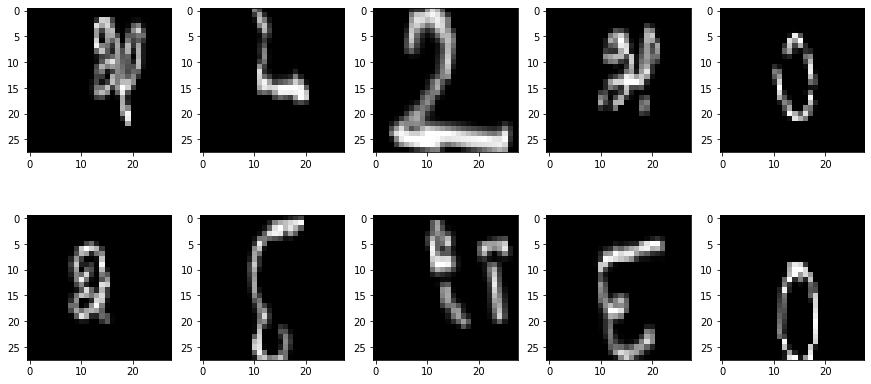

In [29]:
plt.figure(figsize = (15, 7))

for x_batch, y_batch in datagen_train.flow(x_train, y_train, batch_size=10):
    for i in range(0, 10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.show()
    break

In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
datagen_val = ImageDataGenerator()

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau( 
    monitor='loss',    
    # Quantity to be monitored.
    factor=0.25,       
    # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=2,        
    # The number of epochs with no improvement after which learning rate will be reduced.
    verbose=1,         
    # 0: quiet - 1: update messages.
    mode="auto",       
    # {auto, min, max}. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; 
    # in the max mode it will be reduced when the quantity monitored has stopped increasing; 
    # in auto mode, the direction is automatically inferred from the name of the monitored quantity.
    min_delta=0.0001,  
    # threshold for measuring the new optimum, to only focus on significant changes.
    cooldown=0,        
    # number of epochs to wait before resuming normal operation after learning rate (lr) has been reduced.
    min_lr=0.00001     
    # lower bound on the learning rate.
    )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, restore_best_weights=True)

In [31]:
optimizer = Adam(learning_rate=0.01)

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

In [32]:
batch_size = 40
step_train = x_train.shape[0] // batch_size
step_val = x_val.shape[0] // batch_size

history = model.fit(datagen_train.flow(x_train, y_train, batch_size = batch_size),
                              steps_per_epoch = step_train,
                              epochs = 50,
                              validation_data = (x_val, y_val),
                              callbacks = [learning_rate_reduction, es],
                              verbose = 2)

Epoch 1/50
1200/1200 - 19s - loss: 12483.4082 - accuracy: 0.7789 - val_loss: 207.9785 - val_accuracy: 0.9886
Epoch 2/50
1200/1200 - 19s - loss: 2085.3064 - accuracy: 0.8735 - val_loss: 148.6059 - val_accuracy: 0.9920
Epoch 3/50
1200/1200 - 19s - loss: 1417.6788 - accuracy: 0.9006 - val_loss: 119.5812 - val_accuracy: 0.9906
Epoch 4/50
1200/1200 - 19s - loss: 1120.6587 - accuracy: 0.9176 - val_loss: 110.5084 - val_accuracy: 0.9931
Epoch 5/50
1200/1200 - 19s - loss: 866.3029 - accuracy: 0.9284 - val_loss: 173.0976 - val_accuracy: 0.9847
Epoch 6/50
1200/1200 - 20s - loss: 745.1472 - accuracy: 0.9335 - val_loss: 176.9819 - val_accuracy: 0.9841
Epoch 7/50
1200/1200 - 19s - loss: 713.8901 - accuracy: 0.9361 - val_loss: 80.4617 - val_accuracy: 0.9918
Epoch 8/50
1200/1200 - 19s - loss: 603.6149 - accuracy: 0.9418 - val_loss: 69.0710 - val_accuracy: 0.9934
Epoch 9/50
1200/1200 - 19s - loss: 630.6606 - accuracy: 0.9404 - val_loss: 82.5687 - val_accuracy: 0.9942
Epoch 10/50
1200/1200 - 19s - loss:

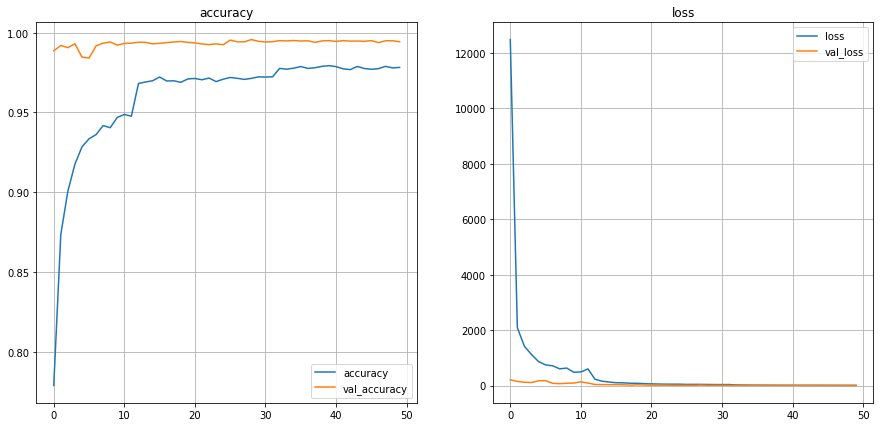

In [33]:
f, ax = plt.subplots(1,2, figsize = (15, 7))
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax = ax[0])
ax[0].grid(True)
ax[0].set_title('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax = ax[1])
ax[1].grid(True)
ax[1].set_title('loss')

plt.show()

### 3-5. Data Augmentation + VGG19

In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),    
    
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(256, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),##
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(alpha=0.1),
 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [35]:
optimizer = Adam(learning_rate=0.01)

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

In [36]:
datagen_train = ImageDataGenerator(rotation_range = 15, # 돌리는 각도 
                             width_shift_range = 0.15, # 0.15 우로 이동, 1 이상이면 픽셀 수로 변환
                             height_shift_range = 0.15, # 0.15 위로 이동, 1 이상이면 픽셀 수로 변환
                             shear_range = 0.15, # 휘어짐 정도
                             zoom_range = 0.4,) # 확대 정도

datagen_train.fit(x_train)

In [37]:
batch_size = 40
step_train = x_train.shape[0] // batch_size
step_val = x_val.shape[0] // batch_size

history = model.fit(datagen_train.flow(x_train, y_train, batch_size = batch_size),
                              steps_per_epoch = step_train,
                              epochs = 100,
                              validation_data = (x_val, y_val),
                              callbacks = [learning_rate_reduction, es],
                              verbose = 2)

Epoch 1/100
1200/1200 - 23s - loss: 0.3581 - accuracy: 0.8833 - val_loss: 0.0603 - val_accuracy: 0.9833
Epoch 2/100
1200/1200 - 23s - loss: 0.1419 - accuracy: 0.9562 - val_loss: 0.0331 - val_accuracy: 0.9897
Epoch 3/100
1200/1200 - 23s - loss: 0.1162 - accuracy: 0.9639 - val_loss: 0.0263 - val_accuracy: 0.9918
Epoch 4/100
1200/1200 - 23s - loss: 0.1016 - accuracy: 0.9688 - val_loss: 0.0277 - val_accuracy: 0.9918
Epoch 5/100
1200/1200 - 23s - loss: 0.0900 - accuracy: 0.9722 - val_loss: 0.0261 - val_accuracy: 0.9918
Epoch 6/100
1200/1200 - 23s - loss: 0.0846 - accuracy: 0.9738 - val_loss: 0.0254 - val_accuracy: 0.9933
Epoch 7/100
1200/1200 - 23s - loss: 0.0805 - accuracy: 0.9736 - val_loss: 0.0275 - val_accuracy: 0.9908
Epoch 8/100
1200/1200 - 23s - loss: 0.0709 - accuracy: 0.9777 - val_loss: 0.0208 - val_accuracy: 0.9948
Epoch 9/100
1200/1200 - 23s - loss: 0.0664 - accuracy: 0.9796 - val_loss: 0.0227 - val_accuracy: 0.9940
Epoch 10/100
1200/1200 - 23s - loss: 0.0615 - accuracy: 0.9805 -

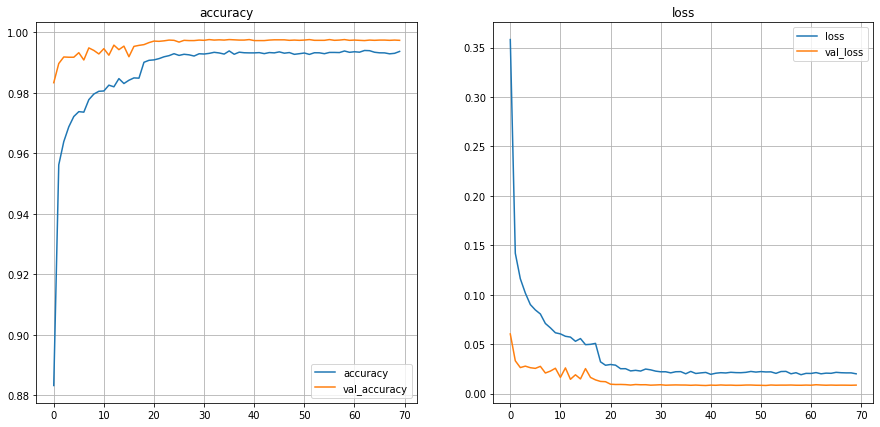

In [38]:
f, ax = plt.subplots(1,2, figsize = (15, 7))
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax = ax[0])
ax[0].grid(True)
ax[0].set_title('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax = ax[1])
ax[1].grid(True)
ax[1].set_title('loss')

plt.show()

# 5. 제출

In [40]:
try:
  sub = pd.read_csv('/kaggle/input/Kannada-MNIST/sample_submission.csv')
except:
  sub = pd.read_csv('./submission.csv')
sub.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


In [41]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis = 1)

In [42]:
sub['label'] = pred
sub.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


In [ ]:
sub.to_csv('./submission.csv', index = False)